In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
%matplotlib inline

from mpl_toolkits.basemap import Basemap
import netCDF4

from scipy import spatial
import matplotlib

import shapely.geometry
import shapely.ops

# My dataset:
## Output from SUNTANS 
### What is SUNTANS
    - Unstructured-grid nonhydrostatic ocean model developed by 
    Stanford
    - Used to simulate nonhydrostatic flows at high resolutions in
    estuaries and coastal seas

### Focus area
    - Galveston Bay
    - Include picture of Galveston Bay satelite image
### Focus time
    - These data files get very big, very quickly.
    - We are going to look at a model run over a short time frame of about
    2 days.
### What is included in this dataset
    - Model output is a netCDF file

In [2]:
nc = netCDF4.Dataset('GalvCoarse_0000.nc')

In [3]:
nc.variables.keys()

odict_keys(['suntans_mesh', 'cells', 'nfaces', 'face', 'edges', 'neigh', 'grad', 'xv', 'yv', 'xp', 'yp', 'xe', 'ye', 'normal', 'n1', 'n2', 'df', 'dg', 'def', 'mark', 'Ac', 'dz', 'z_r', 'z_w', 'Nk', 'Nke', 'dv', 'time', 'eta', 'uc', 'vc', 'w', 'nu_v', 'salt', 'temp', 'rho', 'U', 'Uwind', 'Vwind', 'Tair', 'Pair', 'rain', 'RH', 'cloud', 'Hs', 'Hl', 'Hlw', 'Hsw', 'tau_x', 'tau_y', 'EP'])

In [4]:
nc.dimensions.keys()

odict_keys(['Nc', 'Np', 'Ne', 'Nk', 'Nkw', 'numsides', 'Two', 'time'])

# My goal:
Teach you something about the different ways to deal with and 

## Important variables from netCDF output:
### Variables that define the grid:
    - nodes, xp and yp, size = Np (11373)
    - edges, xe and ye, size = Ne (32858)
    - faces, xv and yv, size = Nv (21484)
    
    Note: All variables are measured at the cell faces 
    (temp, salt, rho, etc.)

### Connectivity variables:
    - Face-face connectivity, neigh 
    - Edge-face connectivity, grad
    - Face-edge connectivity, face
    - Edge-node connectivity, edges
    - Face-node connectivity, cells
    
    Note: each of these variables serves to map one variable to another
    (Will explain more on this later)

In [36]:
#Connectivity variables
neigh = nc['neigh']
grad = nc['grad']
face = nc['face']
cells = nc['cells']
edges = nc['edges']
#Grid variables
xe = nc['xe']
ye = nc['ye']
xp = nc['xp']
yp = nc['yp']
xv = nc['xv']
yv = nc['yv']
#Dependent variables
temp = nc['temp'][20][0]
salt = nc['salt'][20][0]
rho = nc['rho'][20][0]
Hs = nc['Hs'][20]
cloud = nc['cloud'][20]


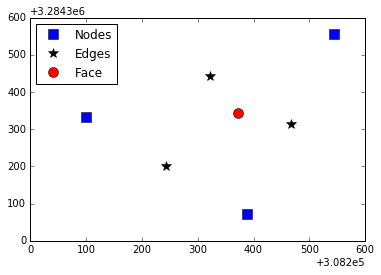

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111)

i=2
#face-node
cell=cells[i]
#face-edge
fac = face[i]

ax.plot(xp[cell],yp[cell],'bs',markersize=10)
ax.plot(xe[fac],ye[fac],'k*',markersize=10)
ax.plot(xv[i],yv[i],'ro',markersize=10)
ax.legend(('Nodes','Edges','Face'),loc=0,numpoints=1)
#ax.plot(xp[cell],yp[cell],'b')
#ax.plot(xe[fac],ye[fac],'k')
#ax.plot([xp[cell[2]],xp[cell[0]]],[yp[cell[2]],yp[cell[0]]],'b')
#ax.plot([xe[fac[2]],xe[fac[0]]],[ye[fac[2]],ye[fac[0]]],'k')


# Plotting Options:
## A. Plotting using scatter plot

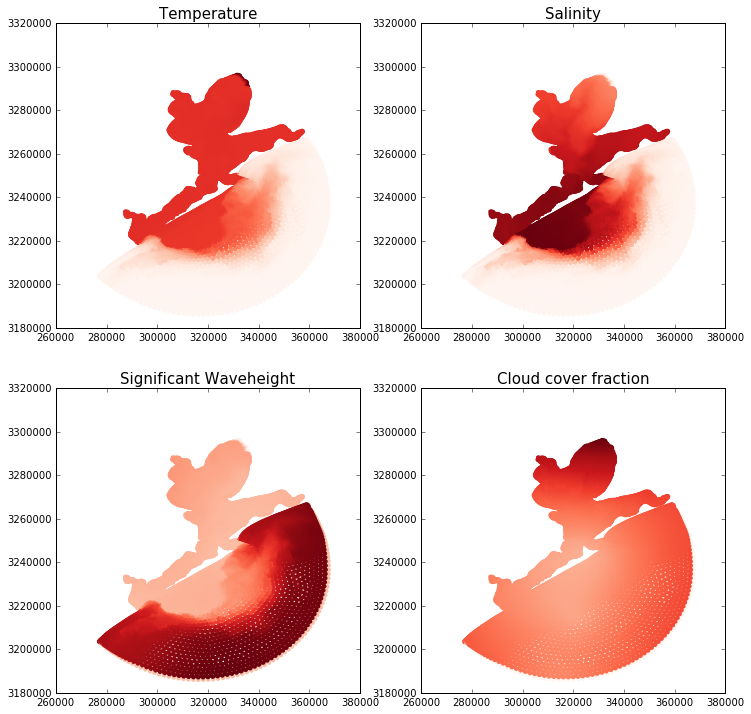

In [46]:
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(221)
ax1.scatter(xv,yv,c=temp,edgecolor='None',cmap='Reds')
ax1.set_title('Temperature',fontsize=15)

ax2 = fig.add_subplot(222)
ax2.scatter(xv,yv,c=salt,edgecolor='None',cmap='Reds')
ax2.set_title('Salinity',fontsize=15)

ax3 = fig.add_subplot(223)
ax3.scatter(xv,yv,c=Hs,edgecolor='None',cmap='Reds')
ax3.set_title('Significant Waveheight',fontsize=15)

ax4 = fig.add_subplot(224)
ax4.scatter(xv,yv,c=cloud,edgecolor='None',cmap='Reds')
ax4.set_title('Cloud cover fraction',fontsize=15)

## B. Plotting on a triangulation
### 1. Create a Delauney triangulation of the data

### Triangulation of the faces
    - Doesn't handle non convex shapes well

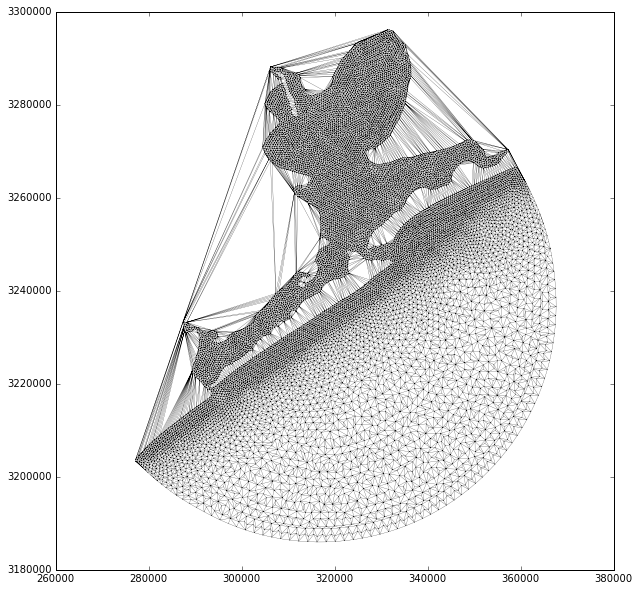

In [57]:
tri_face = matplotlib.tri.Triangulation(np.array(xv),np.array(yv))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.triplot(tri_face,lw=.2,c='k')

### Triangulation of the edges using the edge-face connectivity matrix
    - Includes input triangles=np.asarray(face)
    - size of edge-face connectivity matrix: (Number of faces, 3)
        - For each face point it specifies the indices of the edges to 
        connect to form the triangle around that particular face point

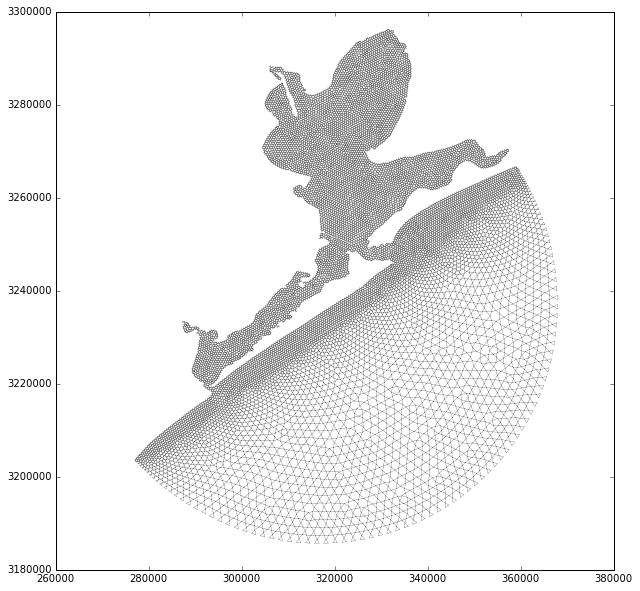

In [56]:
tri_edge = matplotlib.tri.Triangulation(np.array(xe),np.array(ye),triangles=np.asarray(face))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.triplot(tri_edge,lw=.2,c='k')

### Triangulation of the nodes using the node-face-connectivity matrix, cells
    - Also includes input triangles=np.asarray(cells)
    - size of node-face connectivity matrix: (Number of faces, 3)
    - Same as previous but instead of connecting the edges, it connects 
    the nodes
    - This is the triangulation we will be working with for the rest of
    this presentation

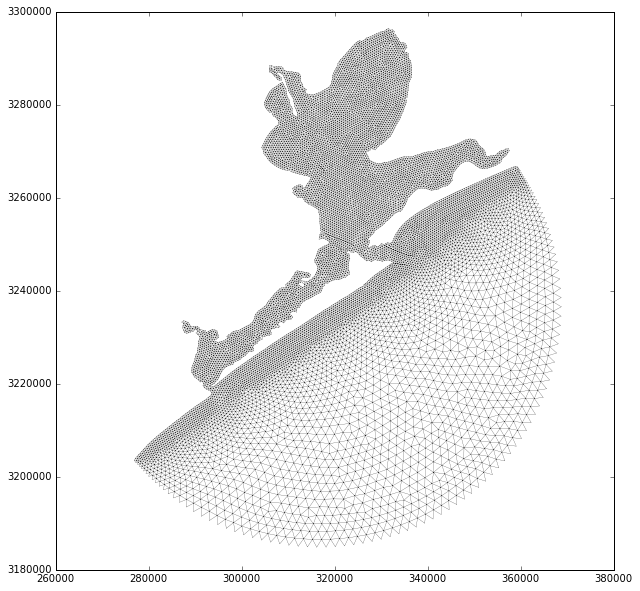

In [55]:
tri_node = matplotlib.tri.Triangulation(np.array(xp),np.array(yp),triangles=np.asarray(cells))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.triplot(tri_node,lw=.2,c='k')

### 2. Different options for triplots within matplotlib
    
    - Triplot
    - Tripcolor
    - Tricontour
    - Tricontourf
    
    *Important characteristics of triangulations:
        - tri.triangles: size = (Number of triangles, 3)
            Gives the locations of the three vertices of each triangle
        - tri.x and tri.y: size = (Number of nodes,)
            Gives the x and y coordinates of each node point used to 
            form the triangulation
    


# Triplot
    - used above
    - Inputs:
        - Only required input is the triangulation you created
        - Can also include keyword arguments and values which are the 
        same as we have used throughout the course for matplotlib
        

# Tripcolor
    - Very similar to plt.pcolor for uniform grids
    - Inputs:
        - Takes the triangulation and an array-like z with length of 
        tri.triangles
        - There is a value for each triangle within the triangulation


<function matplotlib.pyplot.colorbar>

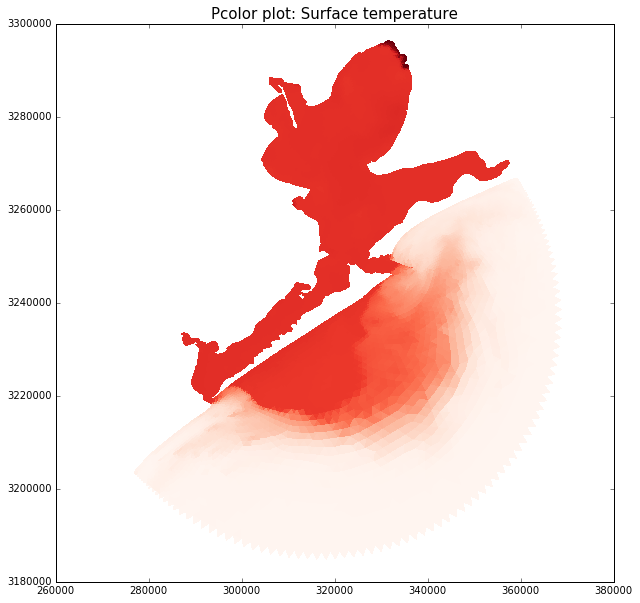

In [96]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

#ax.triplot(tri_node,lw=.2,c='k')
ax.tripcolor(tri_node,temp,cmap='Reds')
ax.set_title('Pcolor plot: Surface temperature', fontsize=15)
plt.colorbar

# Tricontour and tricontourf
    - Similar to plt.contour and plt.contourf
    - Need the values at each point in the triangulation instead of 
    a value per triangle
    - Inputs:
        - Triangluation
        - z values with length tri.x or tri.y

In [72]:
#Need to find values for each node point instead of each triagle:
t=[]
s=[]
h=[]
c=[]
nodetemp=[]
nodesalt=[]
nodeHs=[]
nodecloud=[]

cell = np.asarray(cells)
for i in range(len(xp)):
    new = np.where(cell==i)
    new = np.unique(new)
    for ind in new:
        t.append(temp[ind])
        s.append(salt[ind])
        h.append(Hs[ind])
        c.append(cloud[ind])
    nodetemp.append(np.mean(t))
    nodesalt.append(np.mean(s))
    nodeHs.append(np.mean(h))
    nodecloud.append(np.mean(c))

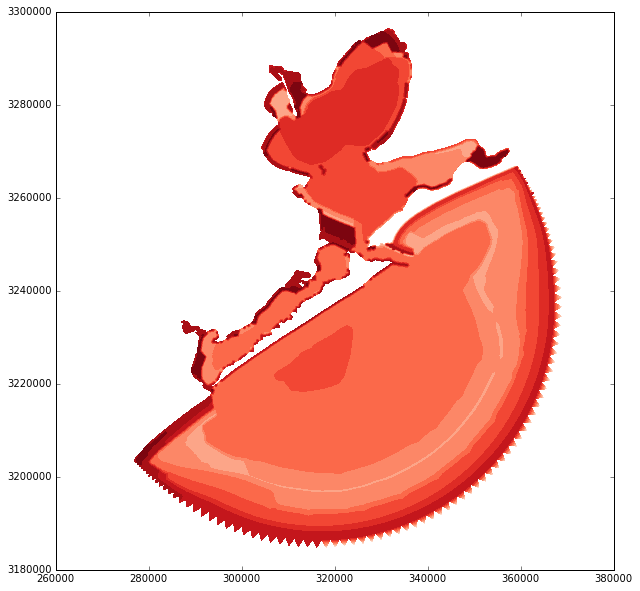

In [95]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
#ax1.triplot(tri_node,lw=.2,c='k')
ax1.tricontourf(tri_node,nodetemp,10,cmap='Reds')


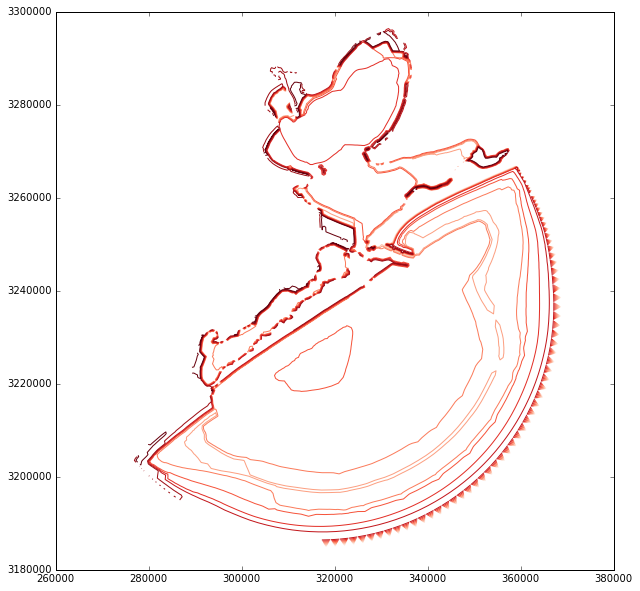

In [97]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
#ax1.triplot(tri_node,lw=.2,c='k')
ax1.tricontour(tri_node,nodetemp,10,cmap='Reds')

